<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/RNN_PSD_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install colorednoise
import colorednoise as cn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
tf.random.set_seed(42)
import seaborn as sns
sns.set_style('darkgrid')

$$
Ftt = \sum a_i \sin(2k\pi)+ i b_i \cos(2k\pi)\\
PSD = (a_i + b_i)(a_i-b_i)\\
PSD = a^2 + b^2\\
S_h = {\sum PSD_i \log(PSD_i) \over \log\left(\frac{1}{N}\right)}
$$

were $b$ in the imaginarius parte

# Functions

In [29]:
def entropyShannon(data,norm=True):
  '''
  Calculate the Shannon spectrum entropy for a given dataseta
  '''
  cdata = tf.cast(data,tf.complex128) #tf complex 128 format
  cdata = tf.signal.fft(cdata) #Fast Fourrie Transformation
  cdata = cdata*tf.math.conj(cdata) #PSD Calculation
  cdata = cdata[:len(cdata)//2] #Take only haf
  cdata = cdata/tf.math.reduce_sum(cdata) #Normalização???
  sh = cdata*tf.math.log(cdata) # Calculate Shannon entropy p1
  sh = tf.math.real(tf.math.reduce_sum(sh)) #Calculate Shannon entropy p2
  if norm == True: #Normalize?
    norm = tf.cast(tf.math.log(1.0/tf.cast(len(cdata),tf.float64) ),tf.float64)
    return cdata, sh/norm
  else:
    return cdata, -sh

def beta(data):
  '''
  Calculate de the PSD loglog power law index
  '''
  psd = tf.cast(data,tf.complex128) #tf complex 128 format
  psd = tf.signal.fft(psd) #FFT me da um vetor complexo
  psd = psd*tf.math.conj(psd) #Complexo conjudado 
  freq = np.fft.fftfreq(len(data)) #mede as frequencias da tranformada de four
  n = len(data)//2 #ponto de conte. Nesse caso é pela metade
  psd = psd[1:n] #Só quero metade dos dados, menos o 1 pq ele estava sendo inf
  freq =  tf.convert_to_tensor(freq[1:n]) #converte para um tensor do tf
  psd = tf.cast(tf.math.log(psd), tf.float64) #convert para log, e só pega o real 
  freq = tf.cast(tf.math.log(freq),tf.float64) #mesma coisa, só que frequencia
  beta, _ =np.polyfit(np.array(freq),np.array(psd),deg=1) #ajuste linear
  return -beta #partiu para o abraço

def diffBeta(d1,d2,n=2):
  return (beta(d1)-beta(d2))**n

def create_dataset(dataset, window_in=10,window_ou=10,window_next=1):
	'''
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  dataX[3] = [3,4,5] ; dataY[3] = [6,7]
  window_next will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
	dataset = dataset.reshape(len(dataset),1)
	dataX, dataY = [], []
	for i in range(0,len(dataset)-window_in-window_ou+1,window_next):
		dataX.append(dataset[i:(i+window_in), 0])
		dataY.append(dataset[i + window_in:i + window_in + window_ou, 0])
	return np.array(dataX), np.array(dataY)  

def plot_test(x_,y_):
  empty = np.empty_like(x_)
  empty[:] = np.nan
  y2 = np.append(empty,y_)
  plt.plot(x_)
  plt.plot(y2)
  #plt.show() 

In [32]:
wn = cn.powerlaw_psd_gaussian(0, 10*2**10)
pn = cn.powerlaw_psd_gaussian(1, 10*2**10)
rn = cn.powerlaw_psd_gaussian(2, 10*2**10)
x,y = create_dataset(rn,512,512,512//2)
for i in range(len(x)):
  print((beta(x[i]),beta(y[i])),diffBeta(x[i],y[i]))

(1.9694205614170426, 1.8069178570475808) 0.026407128927388696
(1.8795242265832115, 2.1089742954394985) 0.05264733409815487
(1.8069178570475808, 1.9782060485342536) 0.029339644542775104
(2.1089742954394985, 1.7817389634411198) 0.10708296250808916
(1.9782060485342536, 1.8341034693930833) 0.020765553315137252
(1.7817389634411198, 2.011683769682006) 0.05287461391715859
(1.8341034693930833, 2.0150448847990368) 0.0327397958091098
(2.011683769682006, 1.80285449705222) 0.0436096651070854
(2.0150448847990368, 1.8356832709445037) 0.032170588524502636
(1.80285449705222, 2.0289294298274307) 0.05110987522931605
(1.8356832709445037, 1.89206972672204) 0.003179432395152071
(2.0289294298274307, 2.065614992744665) 0.0013458305265543681
(1.89206972672204, 1.94468946246139) 0.002768836589279013
(2.065614992744665, 1.95252590223597) 0.012789142392083855
(1.94468946246139, 2.0950321869337034) 0.022602934801757957
(1.95252590223597, 1.8167152538934512) 0.018444532203215295
(2.0950321869337034, 1.847694168021

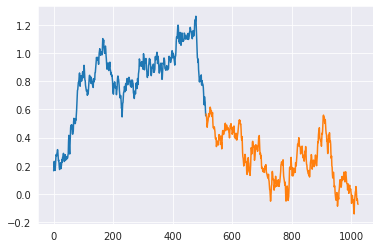

In [33]:
plot_test(x[0],y[0])
plt.show()

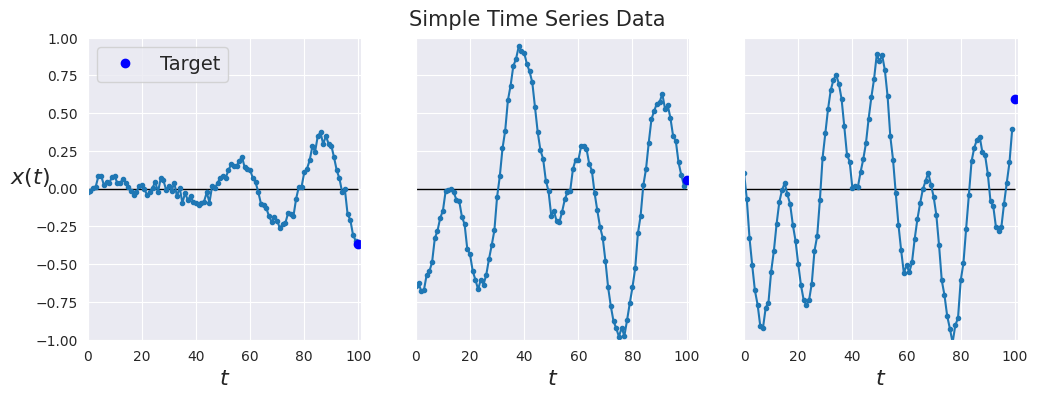

In [217]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4),dpi=100)
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.suptitle('Simple Time Series Data',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
#plt.savefig('P5_Predic_01_data.png',bbox_inches='tight') 
plt.show()